# Цель
Выбор региона для разработки новых нефтяных месторождений

# Задачи
Решить в каком регионе добывать нефть. Построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль с наименьшим риском убытков.

# Описание
Добывающей компании нужно решить, где бурить новую скважину.
Собраны характеристики пробы нефти для скважин: качество нефти и объём её запасов по трем регионам. Характеристики для каждой скважины в регионе уже известны. 
Построена модель для предсказания объёма запасов в новых скважинах.
Выбраны скважины с самыми высокими оценками значений.
Определены регионы с максимальной суммарной прибылью отобранных скважин.
Построена модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализирована возможная прибыль и риски техникой Bootstrap.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from numpy.random import RandomState 

# Section 1
<font size="3">**1. Download and prepare the data.**</font> 

In [2]:
# import all external data
df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

# id — unique oil well identifier
# f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
# product — volume of reserves in the oil well (thousand barrels).

In [3]:
# check if it is imported correctly df_geo_0
print(df_geo_0.head(),'\n')
print(df_geo_1.head(),'\n')
print(df_geo_2.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


**So...** The data import process went well

In [4]:
# check the data: type, statistics and unique values
# type of data:
print(df_geo_0.info(),'\n')
print(df_geo_1.info(),'\n')
print(df_geo_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
mem

**Notice:** no NA-values, *id* is string (OK), others columns are float (OK)

In [5]:
# statistics:
print(df_geo_0.describe(),'\n')
print(df_geo_1.describe(),'\n')
print(df_geo_2.describe())

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347 

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%     

**Notice:**
1. features (f0,f1,f2) could be negative
2. There are outliers: $\mu + 3*\sigma < max $ (detailed below)

In [6]:
# print columns with outliers for each dataframe
def print_outliers(df_column):
    three_sigma = df_column.mean() + 3 * df_column.std()
    maximum = df_column.max()
    if three_sigma >= maximum :
        print ('No outliers        for {:} mu+3*sigma: {:.2} great than {:.2}'.format(
                                                df_column.name, three_sigma, maximum))
    else:
        print ('There are outliers for {:} mu+3*sigma: {:.2} less than {:.2}'.format(
                                                df_column.name, three_sigma, maximum))

print('geo_0:')
print_outliers(df_geo_0.f0)
print_outliers(df_geo_0.f1)
print_outliers(df_geo_0.f2)
print()

print('geo_1:')
print_outliers(df_geo_1.f0)
print_outliers(df_geo_1.f1)
print_outliers(df_geo_1.f2)
print()

print('geo_2:')
print_outliers(df_geo_2.f0)
print_outliers(df_geo_2.f1)
print_outliers(df_geo_2.f2)

geo_0:
No outliers        for f0 mu+3*sigma: 3.1 great than 2.4
No outliers        for f1 mu+3*sigma: 1.8 great than 1.3
There are outliers for f2 mu+3*sigma: 1.2e+01 less than 1.6e+01

geo_1:
There are outliers for f0 mu+3*sigma: 2.8e+01 less than 2.9e+01
There are outliers for f1 mu+3*sigma: 1.1e+01 less than 1.9e+01
No outliers        for f2 mu+3*sigma: 7.6 great than 5.0

geo_2:
There are outliers for f0 mu+3*sigma: 5.2 less than 7.2
There are outliers for f1 mu+3*sigma: 5.2 less than 7.8
There are outliers for f2 mu+3*sigma: 1.3e+01 less than 1.7e+01


**So...** I haven't calculated $\mu - 3*\sigma < min $. But it isn't necessary. <br>
We know that outliers are in the data

In [7]:
# check duplicates in dataframe
print('There are {:} duplicates in df_geo_0'.format(df_geo_0.duplicated().sum()))
print('There are {:} duplicates in df_geo_1'.format(df_geo_1.duplicated().sum()))
print('There are {:} duplicates in df_geo_2'.format(df_geo_2.duplicated().sum()))

There are 0 duplicates in df_geo_0
There are 0 duplicates in df_geo_1
There are 0 duplicates in df_geo_2


**So...** That is good. We shouldn't filter the data

In [8]:
# check unique values
def print_num_uniques(df_column):
    print('{:} unique values: {:}'.format(df_column.name, len(df_geo_0['f0'].unique())))

print('geo_0:')
print_num_uniques(df_geo_0['f0'])
print_num_uniques(df_geo_0['f1'])
print_num_uniques(df_geo_0['f2'])
print_num_uniques(df_geo_0['product'])
print()

print('geo_1:')
print_num_uniques(df_geo_1['f0'])
print_num_uniques(df_geo_1['f1'])
print_num_uniques(df_geo_1['f2'])
print_num_uniques(df_geo_1['product'])
print()

print('geo_2:')
print_num_uniques(df_geo_2['f0'])
print_num_uniques(df_geo_2['f1'])
print_num_uniques(df_geo_2['f2'])
print_num_uniques(df_geo_2['product'])
print()

geo_0:
f0 unique values: 100000
f1 unique values: 100000
f2 unique values: 100000
product unique values: 100000

geo_1:
f0 unique values: 100000
f1 unique values: 100000
f2 unique values: 100000
product unique values: 100000

geo_2:
f0 unique values: 100000
f1 unique values: 100000
f2 unique values: 100000
product unique values: 100000



**So...** All values are unique.

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98e636ad50>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98e621a550>
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98e5c01dd0>


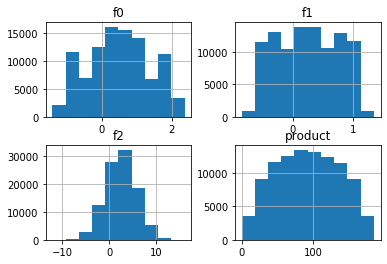

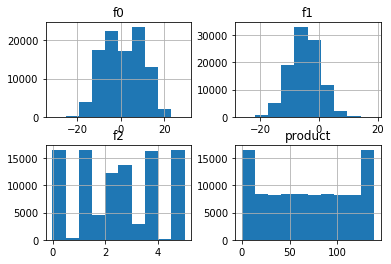

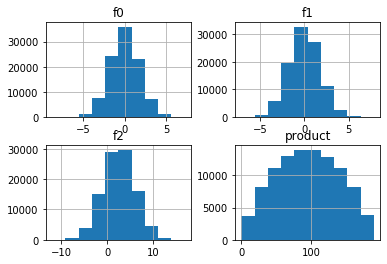

In [9]:
print(df_geo_0.hist())
print(df_geo_1.hist())
print(df_geo_2.hist())

**Notice:** all features and target in df_geo_0 seems to be normal distributed 

In [10]:
# check if it is normal distribution
# null hypothesis: feature or target comes from a normal distribution
# I use stat-library and function normaltest (Pearson’s criteria) to check it

print('df_geo_0:')
for name_col in df_geo_0:
    if name_col != 'id':
        print('P-value of {:}: {:}'.format(name_col, st.normaltest(df_geo_0[name_col]).pvalue))

print('df_geo_1:')
for name_col in df_geo_1:
    if name_col != 'id':
        print('P-value of {:}: {:}'.format(name_col, st.normaltest(df_geo_1[name_col]).pvalue))
        
print('df_geo_2:')
for name_col in df_geo_2:
    if name_col != 'id':
        print('P-value of {:}: {:}'.format(name_col, st.normaltest(df_geo_2[name_col]).pvalue))

df_geo_0:
P-value of f0: 0.0
P-value of f1: 0.0
P-value of f2: 2.5829362598194747e-13
P-value of product: 0.0
df_geo_1:
P-value of f0: 0.0
P-value of f1: 0.03276406499792999
P-value of f2: 0.0
P-value of product: 0.0
df_geo_2:
P-value of f0: 0.5371167431415869
P-value of f1: 0.11763198211551353
P-value of f2: 2.873142751023688e-05
P-value of product: 0.0


**Notice:** we can reject null hypothesis if $P_{value} < \alpha$ <br>
if $\alpha=0.05$ then we can surely reject all but for df_geo_2['f0'] and df_geo_2['f1'] <br>
We expected to find out that all data normally distributed (because the data is synthetic) but it isn't so.

<div class="alert alert-info">
    <b>- Can you explain why we need to test the data for normality? </b> <br>
    The instructions for this issue indicate that the data is synthetic. When I saw how the histograms are distributed, it seemed to me that they correspond to a normal distribution. I became <b>curious</b> if this synthetic data was just being created as a collection of synthetically normally distributed values. I checked and realized that it was not. <br>
    From the point of view of the task itself, there was no need to do this. But I haven't deleted the code, because I thought that it could be interesting findings. <br>
    <b>- Also, why does the data being synthetic lead you to expect the data to be normally distributed? </b> <br>
    Synthetic data shouldn't be normally distributed. It was an assumption based on the view of histograms. Normal distribution is like a gold standard of distributions, in my opinion of course. We encountered with normal (Gauss) disribution in physics, biology. We don't know about this feature-values (f0, f1, f2) but we know that they related with geology. It means nothing about distribution, but it was intersting for me to check it.<br>
    <b>- Can't we synthesize data from pretty much any distribution? </b> <br>
     Of course we can. And in life we encounter different distributions. Classical example is Poisson distribution (number of events in interval), beta-distribution, gamma, lognormal and so on. And we can use them to create synthetic data.
</div>

# Results of Section 1
<font size="2">
1. <b> Data has been imported correctly</b>. We have 3 tables. <br>
2. There are no NA-values and duplicates. All values are unique in their columns. <br>
3. Types of data are correct. <br>
4. <b> Exploratory Data Analysis(EDA) is not necessary </b> here. Data is well prepared for developing a model. <br>
5. With high probability df_geo_2['f0'] and df_geo_2['f1'] are normally distributed (data is synthetic; we can't reject hypothesis)
    
    


# PS
**About scaling and standartization of features (f1,f2 and f3)** <br>
We haven't scaled the data because of (a) I forgot it... (but after I have done this project I read about it in our Slack channel), (b) after reading slack I understand that it is not important here, when we use linear regression. <br>
<br> Dmitry Donetskov / Дмитрий Донецков: <br>
Mathematically, Linear Regression does not require transforming numerical features to a same scale, that's because every feature/predictor receives its own coefficient and their values are calculated with respect to range of relevant feature/predictor. <br>
Computationally though, extreme (very large) values of features may impact so-called computational stability of Linear Regression algorithm. It may lead to issues with computing coefficients, near zero values of coefficients etc. <br>
So, the scaling is not necessary for LR unless there are extreme values for some of predictors, the latter can be scaled to help algorithm with keeping significant digits while computing coefficients.

# Section 2
<font size="3">**2. Train and test the model for each region:<br>
2.1 [x] Split the data into a training set and validation set at a ratio of 75:25.<br>
2.2.[x] Train the model and make predictions for the validation set.<br>
2.3.[x] Save the predictions and correct answers for the validation set.<br>
2.4.[x] Print the average volume of predicted reserves and model RMSE.<br>
2.5.[x] Analyze the results. <br>**</font> 
Note: we should use only linear regression

In [11]:
# we defined a new function because we need triple times use it in different regions
# it is important that we can fit model in seconds (it is not time consuming)
def rmse_linear_model(df):
    features = df[['f0','f1','f2']] # we don't use id, as it doesn't influence on the target value
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
                    features, target, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('RMSE: {:.2f}'.format(mean_squared_error(target_valid, predicted_valid)**0.5))
    return model.predict(features)

In [12]:
print('Region 0:')
predicted_values = rmse_linear_model(df_geo_0)
df_geo_0['prod_predicted'] = predicted_values
print('Region 1:')
predicted_values = rmse_linear_model(df_geo_1)
df_geo_1['prod_predicted'] = predicted_values
print('Region 2:')
predicted_values = rmse_linear_model(df_geo_2)
df_geo_2['prod_predicted'] = predicted_values

Region 0:
RMSE: 37.58
Region 1:
RMSE: 0.89
Region 2:
RMSE: 40.03


In [13]:
def plot_predictions(x,y):
    plt.figure()
    plt.plot(x, y, '.')
    plt.plot([0, 200], [0, 200], linestyle='--')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    plt.ylabel("Product")
    plt.xlabel("Predited reserves")
    plt.title("Predicted vs True")
    plt.show()

Region 0:


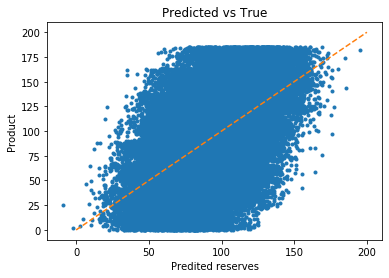

Region 1:


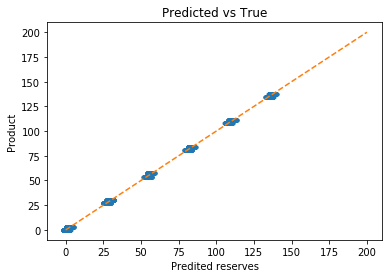

Region 2:


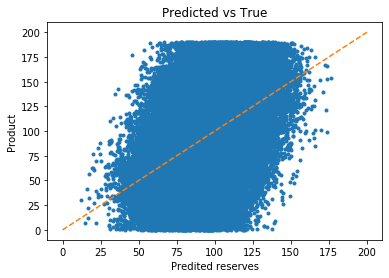

In [14]:
print('Region 0:')
plot_predictions(df_geo_0['prod_predicted'],df_geo_0['product'])
print('Region 1:')
plot_predictions(df_geo_1['prod_predicted'],df_geo_1['product'])
print('Region 2:')
plot_predictions(df_geo_2['prod_predicted'],df_geo_2['product'])

# Results of Section 2
<font size="2">
1. We developed model to predict target value. <br>
2. Good prediction should deviate around the line $ y = x $ <br>
3. It doesn't look like a good prediction for Region 0 (RMSE is 37.58) and Region 1 (RMSE is 40.03). Plots show how they deviate from the correct values. <br>
4. It is a very good prediction for Region 1. RMSE is 0.89. It is super perfect. <br>

# Section 3
<font size="3">**3. Prepare for profit calculation:<br>
3.1. Store all key values for calculations in separate variables.<br>
3.2. Calculate the volume of reserves sufficient for developing a new well without losses. Compare the obtained value with the average volume of reserves in each region.<br>
3.3. Provide the findings about the preparation for profit calculation step. <br>**</font> 

In [15]:
# key values
num_wells_region = 500 # study of 500 points is carried
num_wells_best = 200   # pick the best 200 points for the profit calculation
budget = 1e8           # budget to drill best wells
price_barrel = 4.5     # price of 1 barrel
risk_bound = 0.025     # keep only the regions with the risk of losses lower than 2.5%

In [16]:
# calculate cost of 1 well based on total budget
cost_one_well = 1.0 * budget / num_wells_best

# calculate what volume of reserves we need to obtain based on the available budget
volume_reserves_zero_profit = 1.0 * budget / price_barrel
# print it
text = 'Total volume of reserves we should obtain in case of zero profit:'
print(' {:} {:.1} thousand of barrels'.format(text, volume_reserves_zero_profit / 1000))

# calculate what volume of reserves **by 1 well** we need to obtain
volume_reserves_one_well_zero_profit = 1.0 * budget / price_barrel / num_wells_best
# print it
text = 'The volume of reserves sufficient for developing a new well without losses:'
print(' {:} {:.2f} thousand of barrels'.format(text, volume_reserves_one_well_zero_profit / 1000))

 Total volume of reserves we should obtain in case of zero profit: 2e+04 thousand of barrels
 The volume of reserves sufficient for developing a new well without losses: 111.11 thousand of barrels


**Notice:**
1. Average volume of predicted reserves in Region 0: 92.59; Region 1: 68.73; Region 2: 94.97;  <br>
The volume of reserves sufficient for developing a new well without losses: 111.11. <br>
That is, our economic (when we calculate average volume in all wells) is not profitable. <br>
Nevertheless it could become better when we select the best wells, especially if our prediction model is good.

# Results of Section 3
<font size="2">
1. Now we ready to evaluate profit for each region. <br>
2. Our budget is supposed to drill 200 oil wells. Null-profit volume of reserves in one well is 111.11 kbbl (thousand of barrels). According to our model each well in Region 0 in average could give us 92.59 kbbl (less). However mean-value doesn't give us information about deviations from it. If we have very good model and if standard deviation is high we will obtain a good economic in the next step. <br>
3. We can suppose that Region 1 have a good chances to be the best region. Let's check our guesses.

# Section 4
<font size="3">**4. Write a function to calculate profit from a set of selected oil wells and model predictions:<br>
4.1. [x] Pick the wells with the highest values of predictions.<br>
4.2. [x] Summarize the target volume of reserves in accordance with these predictions<br>
4.3. Provide findings: suggest a region for oil wells' development and justify the choice. Calculate the profit for the obtained volume of reserves.**</font> 

In [17]:
# define funtion to calculate profit of the wells
def calculate_profit(model_volume, real_volume, num):
    index_best_well = model_volume.sort_values(ascending=False)[:num].index # find index of the best wells
    real_volume = real_volume[index_best_well] # find real volume of reserves in the best wells
    total_volume = real_volume.sum() # return total volume of reserves in the best wells
    return total_volume * price_barrel * 1e3 - budget # return profit (revenue minus budget)

**Notice:** <br>
I understand 4.3 as an initial assessment of choosing the region. We will obtain final result **only after bootstrap analysis**.

In [18]:
sample = df_geo_0.sample(num_wells_region, random_state=12345)
print('Region0 profit: {:.2f}'.format(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best)))
sample = df_geo_1.sample(num_wells_region, random_state=12345)
print('Region1 profit: {:.2f}'.format(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best)))
sample = df_geo_2.sample(num_wells_region, random_state=12345)
print('Region2 profit: {:.2f}'.format(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best)))

Region0 profit: 1967713.97
Region1 profit: 3121725.38
Region2 profit: -173046.57


**Notice:** <br>
! It is based only on the one random sample !
1. I can't say what region is the best based only on this data, because of the random when we select the sample. <br>
Now we can suggest that it is Region 1. In the next section we will know for sure.
2. Our Region1 revenue (103.1 mln USD) > our budget (100.0 mln USD). It is a good sign!

# Results of Section 4
<font size="2">
1. Function to evaluate profit is ready . <br>
2. **It is based only on the one random sample** I can't say what region is the best based only on this data, because of the random when we select the sample. <br>
Now we can suggest that it is Region 1. In the next section we will know for sure. <br>
3. Our Region1 profit is positive +3 mln USD. It is a good sign!

# Section 5
<font size="3">**5. Calculate risks and profit for each region:<br>
5.1. Use the bootstrapping technique with 1000 samples to find the distribution of profit.<br>
5.2. Find average profit, 95% confidence interval and risk of losses. Loss is negative profit, calculate it as a probability and then express as a percentage.<br>
5.3. Provide findings: suggest a region for development of oil wells and justify the choice.**</font> 

In [19]:
# save profits during bootstrapping
state = RandomState(12345)

profit_region_0 = []
profit_region_1 = []
profit_region_2 = []

for k in range(1000):
    sample = df_geo_0.sample(num_wells_region, replace=True, random_state=state)
    profit_region_0.append(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best))
    
    sample = df_geo_1.sample(num_wells_region, random_state=state)
    profit_region_1.append(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best))
    
    sample = df_geo_2.sample(num_wells_region, random_state=state)
    profit_region_2.append(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best))

# find average profit
average_profit_region_0 = pd.Series(profit_region_0).mean()
average_profit_region_1 = pd.Series(profit_region_1).mean()
average_profit_region_2 = pd.Series(profit_region_2).mean()
print('Average profit Region 0:', average_profit_region_0)
print('Average profit Region 1:', average_profit_region_1)
print('Average profit Region 2:', average_profit_region_2)

Average profit Region 0: 4792506.986625174
Average profit Region 1: 4553627.114171754
Average profit Region 2: 3591671.7082301653


**So:** The average profit in each region is positive. The least one is Region 2 with 3.6 mln USD, the largest is Region 0 with approximately 4.8 mln USD.

In [20]:
# 95% confidence interval using the Student distribution
confidence_interval = st.t.interval(0.95, len(profit_region_0)-1, 
                                    loc=pd.Series(profit_region_0).mean(),
                                    scale=pd.Series(profit_region_0).sem()) 

print("Region 0 confidence interval 95%:", confidence_interval)

# 95% confidence interval using the Student distribution
confidence_interval = st.t.interval(0.95, len(profit_region_1)-1, 
                                    loc=pd.Series(profit_region_1).mean(),
                                    scale=pd.Series(profit_region_1).sem()) 

print("Region 1 confidence interval 95%:", confidence_interval)

# 95% confidence interval using the Student distribution
confidence_interval = st.t.interval(0.95, len(profit_region_2)-1, 
                                    loc=pd.Series(profit_region_2).mean(),
                                    scale=pd.Series(profit_region_2).sem()) 

print("Region 2 confidence interval 95%:", confidence_interval)

Region 0 confidence interval 95%: (4620789.201413887, 4964224.7718364615)
Region 1 confidence interval 95%: (4426591.372906486, 4680662.855437022)
Region 2 confidence interval 95%: (3426040.1097355834, 3757303.306724747)


**So:** In the 95% confidence interval only positive profit!

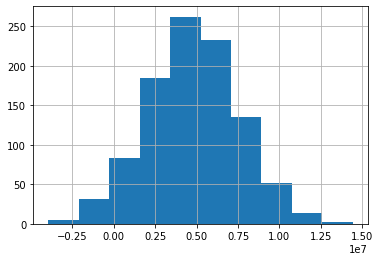

In [21]:
pd.Series(profit_region_0).hist()

In [22]:
# risk of looses determined by the negative profit
print('Region 0 risk of looses: {:}%'.format(st.percentileofscore(pd.Series(profit_region_0), 0)))
print('Region 1 risk of looses: {:}%'.format(st.percentileofscore(pd.Series(profit_region_1), 0)))
print('Region 2 risk of looses: {:}%'.format(st.percentileofscore(pd.Series(profit_region_2), 0)))

Region 0 risk of looses: 4.8%
Region 1 risk of looses: 1.4%
Region 2 risk of looses: 8.8%


# Results of Section 5
<font size="2">
<div class="alert alert-info">
    <b>V2.</b>
    Remember, that we should keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.<br>
1. The best region is Region 1. It has very low risk to be not profitable (only 1.4%), more it has high profit in between (4426591.372906486, 4680662.855437022) USD with confidence 95% <br>
</div>
2. The other regions could loose (Region 1: 4.8%, Region 2: 8.8%). <br>
Region 0 confidence interval 95%: (4620789.201413887, 4964224.7718364615) <br>
Region 2 confidence interval 95%: (3426040.1097355834, 3757303.306724747)

# Conclusion

The best place for a new well: **Region 1**. <br>
It has low chance to be unprofitable only 0.7%. <br>
The profit is the highest: 4.44-4.69 mln dollars with confidence 95%. <br>
We developed a very good model to predict wells reserves. RMSE of selected region: 0.89. <br>
As we can see in the plot we can even classify "bad" and "good" wells.